In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [4]:
def calc_ios(df):
    PAGESIZE = 4096
    for mode in ['nominal', 'robust']:
        if (df[f'{mode}_compact_write'].sum() < 1):
            df[f'{mode}_io'] = df[f'{mode}_blocks_read']
        else:
#             for mode in ['nominal', 'robust']:
            workload_weight = df['w_s'] / df['w_s'].sum()
            compaction_io = np.sum((df[f'{mode}_compact_read'] + df[f'{mode}_compact_write']) / PAGESIZE)
            df[f'{mode}_write_io'] = (workload_weight * compaction_io) + ((df[f'{mode}_bytes_written'] + df[f'{mode}_flush_written']) / PAGESIZE)
            df[f'{mode}_io'] = df[f'{mode}_blocks_read'] + df[f'{mode}_write_io']
    
    return df

def calc_latency(df, readonly=False):
    for mode in ['nominal', 'robust']:
        if readonly:
            write_ms = 0
        # Since we open and close the DB each workload we must spread out the waiting for compaction cost
        # as normally when we operate we would not stop all operations during backgorund compactions
        elif f'{mode}_compact_ms' not in df.columns:
            write_ms = 0
            write_ms = df[f'{mode}_w_ms'].sum()
            workload_weight = df['w_s'] / df['w_s'].sum()
            compact_normal_ms = write_ms * workload_weight
            write_ms = compact_normal_ms
        else:
            compact_normal_sum = df[f'{mode}_compact_ms'].sum() 
            workload_weight = df['w_s'] / df['w_s'].sum()
            compact_normal_ms = compact_normal_sum * workload_weight
            write_ms = df[f'{mode}_w_ms'] + compact_normal_ms
        df[f'{mode}_ms'] = (
            df[f'{mode}_z0_ms'] 
            + df[f'{mode}_z1_ms']
            + df[f'{mode}_q_ms']
            + write_ms)
        df[f'{mode}_ms_p_query'] = df[f'{mode}_ms'] / df['num_queries']
    
    return df

def calc_throughput(df):
    for mode in ['nominal', 'robust']:
        df[f'{mode}_tp'] = df['num_queries'] / df[f'{mode}_ms']
        
    return df

def prep(df, readonly=False):
    df = calc_ios(df)
    df = calc_latency(df, readonly)
    df = calc_throughput(df)
    
    return df

def apply_design(df, cf, z0, z1, q, w, mode='nominal'):
    cf.z0, cf.z1, cf.q, cf.w = z0, z1, q, w
    cost = cf.calculate_cost(df[f'{mode}_m_filt'] / cf.N, np.ceil(df[f'{mode}_T']), df[f'{mode}_is_leveling_policy'])
    return cost

In [5]:
def plot_system_cost_sessions(df, ax):
    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df['nominal_io'] / df['num_queries'], df['robust_io'] / df['num_queries']
    
    ax.text(0.04, 0.82, 'System I/O', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

In [6]:
def plot_model_cost_sessions(df, ax, w0, w_hat):
    distance = np.sum(rel_entr(w_hat, w0))
    
    cfg = config['lsm_tree_config'].copy()
    cfg['N'], cfg['M'] = df.iloc[0].N, df.iloc[0].M
    cf = CostFunction(**cfg, z0=w_hat[0], z1=w_hat[1], q=w_hat[2], w=w_hat[3])
    df['nominal_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'nominal'), axis=1)
    df['robust_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'robust'), axis=1)

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df['nominal_cost'], df['robust_cost']
    
    ax.text(0.04, 0.82, 'Model I/O', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

In [7]:
def plot_latency_sessions(df, ax):
    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
#     y1, y2 = df['nominal_ms'] / df['num_queries'], df['robust_ms'] / df['num_queries']
    y1, y2 = df['nominal_ms_p_query'], df['robust_ms_p_query'] 
    
    ax.text(0.02, 0.82, 'System Latency', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.set_ylabel('Latency (ms) per Query', labelpad=10)
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

def plot_throughput_sessions(df, ax):
    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df['nominal_tp'], df['robust_tp'] 
    
    ax.text(0.02, 0.82, 'System Throughput', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels([]), ax.set_xticks([])
    ax.set_ylabel('Queries per ms', labelpad=10)
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8,
            label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}\n$\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8,
            label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}\n$\pi$: {robust_policy}')
    
    return ax

In [8]:
def plot_cost_sessions(df, graphs=(True, True, True, True), readonly=False):
    sys, model, latency, throughput = graphs
    robust_rho = df.rho.iloc[0]
    num_sessions = int(df.session_id.max()) + 1
    samples = df[df['session_id'] == 0].shape[0]
    session_means = []
    for idx in range(0, df.shape[0], samples):
        session_means.append(df.iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w0 = [df['z0'].iloc[0], df['z1'].iloc[0], df['q'].iloc[0], df['w'].iloc[0]]
    distance = np.sum(rel_entr(w_hat, w0))

    fig, axes = plt.subplots(ncols=1, nrows=sum(graphs), tight_layout=True)
    axes = [axes] if sum(graphs) == 1 else axes
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
            
    # Graphs
    axes_it = iter(axes)
    if model:
        plot_model_cost_sessions(df, next(axes_it), w0, w_hat)
    if sys:
        plot_system_cost_sessions(df, next(axes_it))
    if latency:
        plot_latency_sessions(df, next(axes_it))
    if throughput:
        plot_throughput_sessions(df, next(axes_it))
    
        
    if sys and model:
        tmp_fig = axes[0].get_figure()
        ax0 = tmp_fig.add_subplot(111, frame_on=False)
        ax0.set_xticks([]), ax0.set_yticks([])
        ax0.set_ylabel('I/Os per Query', labelpad=25)
        x, y = ax0.yaxis.label.get_position()
        ax0.yaxis.set_label_coords(x - 0.03, y + 0.25)
    elif sys or model:
        axes[0].set_ylabel('I/Os per Query')
    first_ax = axes[0]
    l = first_ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2, borderpad=0.2, labelspacing=-0.1)
    l.get_texts()[-1].set_color('tab:green')
    first_ax.text(0.845, 0.85,
        '$\mathbf{w}_{' + f'{wl_idx if wl_idx < 15 else ""}' + '}:\ $' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)',
        transform=first_ax.transAxes, fontsize=13)
    first_ax.text(0.845, 0.65,
        '$\mathbf{\hat{w}}:\ $' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)',
        transform=first_ax.transAxes, fontsize=13)

    # Last axes label
    last_ax = axes[-1]
    last_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    x_loc = [0.025, 0.200, 0.360, 0.535, 0.700, 0.870]
    for idx, x in enumerate(x_loc):
        z0, z1, q, w = session_means[idx]
        last_ax.text(x, -0.38, f'({(z0 * 100):.0f}%, {(z1 * 100):.0f}%, {(q  * 100):.0f}%, {(w  * 100):.0f}%)', alpha=1, transform=last_ax.transAxes)
    
    if readonly:
        last_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Reads', '6. Reads'])
    else:
        last_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])

    ax = axes[-2]
    ax.text(0.845, 0.85, r'$\rho :$' + f'{robust_rho:.2f}', transform=ax.transAxes, fontsize=13)
    ax.text(0.845, 0.65, '$I_{KL}(\mathbf{\hat{w}}, \mathbf{w}) :$' + f'{distance:.2f}', transform=ax.transAxes, fontsize=13)

    return fig, axes

In [9]:
df = dp.read_csv('vldb/exp_03_pt02.csv')
df.describe()

workload_idx          z0          z1           q           w  \
count    510.000000  510.000000  510.000000  510.000000  510.000000   
mean       8.000000    0.255294    0.238235    0.238235    0.262353   
std        4.903789    0.265193    0.258784    0.258784    0.284274   
min        0.000000    0.010000    0.010000    0.010000    0.010000   
25%        4.000000    0.010000    0.010000    0.010000    0.010000   
50%        8.000000    0.250000    0.200000    0.200000    0.250000   
75%       12.000000    0.490000    0.330000    0.330000    0.490000   
max       16.000000    0.970000    0.970000    0.970000    0.970000   

                N    phi      B      s       E            M  nominal_m_filt  \
count       510.0  510.0  510.0  510.0   510.0        510.0    5.100000e+02   
mean   10000000.0    1.0    4.0    0.0  8192.0  108388608.0    4.408403e+07   
std           0.0    0.0    0.0    0.0     0.0          0.0    3.122261e+07   
min    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    0.000000e+00   
25%    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    2.715821e+07   
50%    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    4.668040e+07   
75%    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    6.884796e+07   
max    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    9.428344e+07   

       nominal_m_buff   nominal_T  nominal_cost  nominal_bpe         rho  \
count    5.100000e+02  510.000000    510.000000   510.000000  510.000000   
mean     6.430458e+07   22.612010      1.739579     4.408403    0.912008   
std      3.122261e+07   27.801847      1.006159     3.122261    0.502461   
min      1.410517e+07    2.340179      0.136679     0.000000    0.006482   
25%      3.954065e+07    5.153400      1.186007     2.715821    0.512200   
50%      6.170821e+07    6.157890      1.532864     4.668040    1.003153   
75%      8.123040e+07   32.769621      2.519627     6.884796    1.223508   
max      1.083886e+08  100.000000      4.065812     9.428344    1.766439   

       robust_exit_mode  robust_m_filt  robust_m_buff    robust_T  \
count             510.0   5.100000e+02   5.100000e+02  510.000000   
mean                0.0   1.761790e+07   9.077071e+07    5.576029   
std                 0.0   1.124552e+07   1.124552e+07    2.091847   
min                 0.0   1.000000e+07   6.627100e+07    2.799313   
25%                 0.0   1.000000e+07   8.068713e+07    4.599113   
50%                 0.0   1.000000e+07   9.838861e+07    5.024902   
75%                 0.0   2.770147e+07   9.838861e+07    5.443043   
max                 0.0   4.211760e+07   9.838861e+07   10.568843   

       robust_cost  robust_bpe   sample_idx  num_queries        z0_s  \
count   510.000000  510.000000   510.000000        510.0  510.000000   
mean      2.309005    1.761790  5575.870588     200000.0    0.281315   
std       1.119406    1.124552  2667.843825          0.0    0.321910   
min       0.337212    1.000000    88.000000     200000.0    0.000000   
25%       1.542854    1.000000  3729.000000     200000.0    0.030450   
50%       2.204229    1.000000  5618.500000     200000.0    0.094100   
75%       3.149924    2.770147  8100.000000     200000.0    0.473700   
max       4.117316    4.211760  9822.000000     200000.0    0.932700   

             z1_s         q_s         w_s      kl_div  session_id  \
count  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.276006    0.220001    0.222697    1.596255    2.500000   
std      0.297178    0.309041    0.306462    1.478254    1.709502   
min      0.000000    0.000000    0.000000    0.002717    0.000000   
25%      0.045500    0.016400    0.023500    0.325937    1.000000   
50%      0.120000    0.067800    0.078300    0.836728    2.500000   
75%      0.498725    0.202375    0.151050    3.389133    4.000000   
max      0.897100    0.878800    0.892900    4.330997    5.000000   

       nominal_l0_hit  nominal_l1_hit  nominal_l2_plus_hit  nominal_z0_ms  \


workload_idx          z0          z1           q           w  \
count    510.000000  510.000000  510.000000  510.000000  510.000000   
mean       8.000000    0.255294    0.238235    0.238235    0.262353   
std        4.903789    0.265193    0.258784    0.258784    0.284274   
min        0.000000    0.010000    0.010000    0.010000    0.010000   
25%        4.000000    0.010000    0.010000    0.010000    0.010000   
50%        8.000000    0.250000    0.200000    0.200000    0.250000   
75%       12.000000    0.490000    0.330000    0.330000    0.490000   
max       16.000000    0.970000    0.970000    0.970000    0.970000   

                N    phi      B      s       E            M  nominal_m_filt  \
count       510.0  510.0  510.0  510.0   510.0        510.0    5.100000e+02   
mean   10000000.0    1.0    4.0    0.0  8192.0  108388608.0    4.408403e+07   
std           0.0    0.0    0.0    0.0     0.0          0.0    3.122261e+07   
min    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    0.000000e+00   
25%    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    2.715821e+07   
50%    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    4.668040e+07   
75%    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    6.884796e+07   
max    10000000.0    1.0    4.0    0.0  8192.0  108388608.0    9.428344e+07   

       nominal_m_buff   nominal_T  nominal_cost  nominal_bpe         rho  \
count    5.100000e+02  510.000000    510.000000   510.000000  510.000000   
mean     6.430458e+07   22.612010      1.739579     4.408403    0.912008   
std      3.122261e+07   27.801847      1.006159     3.122261    0.502461   
min      1.410517e+07    2.340179      0.136679     0.000000    0.006482   
25%      3.954065e+07    5.153400      1.186007     2.715821    0.512200   
50%      6.170821e+07    6.157890      1.532864     4.668040    1.003153   
75%      8.123040e+07   32.769621      2.519627     6.884796    1.223508   
max      1.083886e+08  100.000000      4.065812     9.428344    1.766439   

       robust_exit_mode  robust_m_filt  robust_m_buff    robust_T  \
count             510.0   5.100000e+02   5.100000e+02  510.000000   
mean                0.0   1.761790e+07   9.077071e+07    5.576029   
std                 0.0   1.124552e+07   1.124552e+07    2.091847   
min                 0.0   1.000000e+07   6.627100e+07    2.799313   
25%                 0.0   1.000000e+07   8.068713e+07    4.599113   
50%                 0.0   1.000000e+07   9.838861e+07    5.024902   
75%                 0.0   2.770147e+07   9.838861e+07    5.443043   
max                 0.0   4.211760e+07   9.838861e+07   10.568843   

       robust_cost  robust_bpe   sample_idx  num_queries        z0_s  \
count   510.000000  510.000000   510.000000        510.0  510.000000   
mean      2.309005    1.761790  5575.870588     200000.0    0.281315   
std       1.119406    1.124552  2667.843825          0.0    0.321910   
min       0.337212    1.000000    88.000000     200000.0    0.000000   
25%       1.542854    1.000000  3729.000000     200000.0    0.030450   
50%       2.204229    1.000000  5618.500000     200000.0    0.094100   
75%       3.149924    2.770147  8100.000000     200000.0    0.473700   
max       4.117316    4.211760  9822.000000     200000.0    0.932700   

             z1_s         q_s         w_s      kl_div  session_id  \
count  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.276006    0.220001    0.222697    1.596255    2.500000   
std      0.297178    0.309041    0.306462    1.478254    1.709502   
min      0.000000    0.000000    0.000000    0.002717    0.000000   
25%      0.045500    0.016400    0.023500    0.325937    1.000000   
50%      0.120000    0.067800    0.078300    0.836728    2.500000   
75%      0.498725    0.202375    0.151050    3.389133    4.000000   
max      0.897100    0.878800    0.892900    4.330997    5.000000   

       nominal_l0_hit  nominal_l1_hit  nominal_l2_plus_hit  nominal_z0_ms  \


# Plot all possible workloads

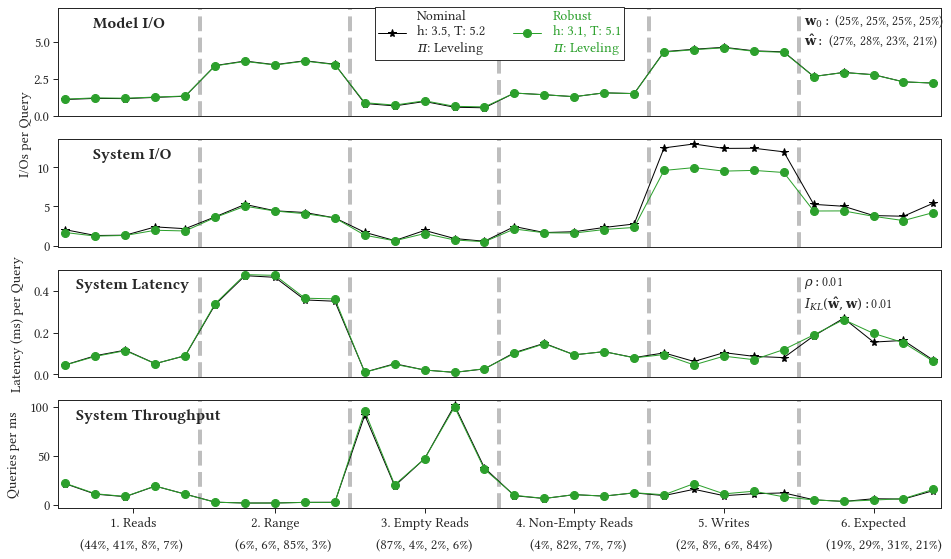

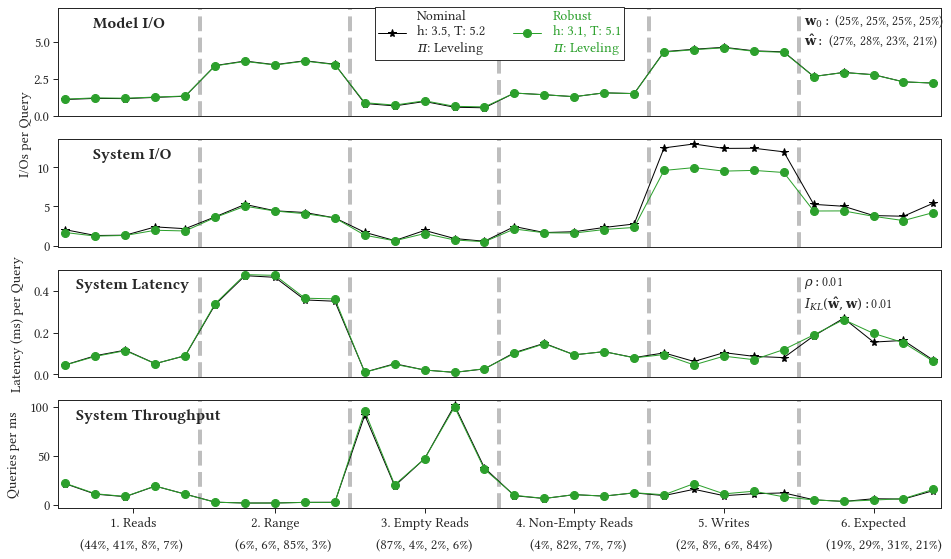

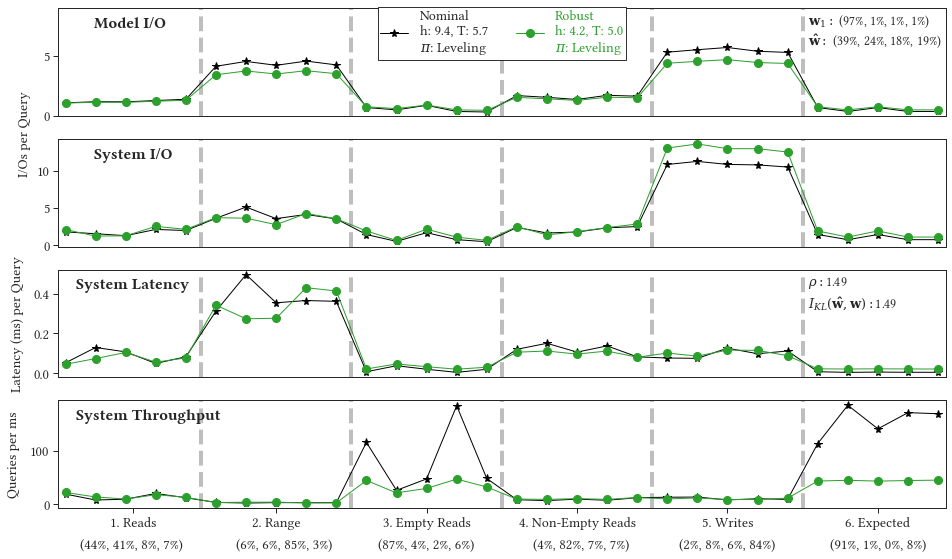

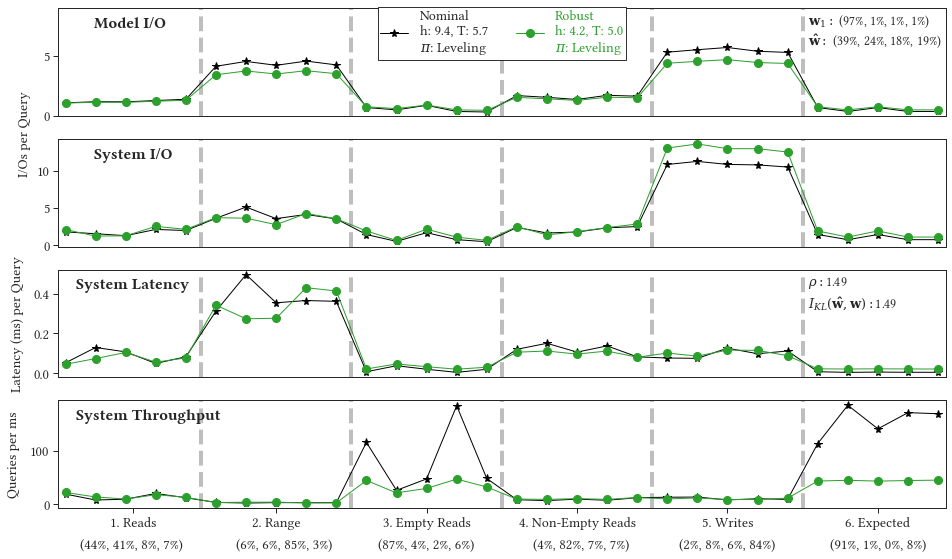

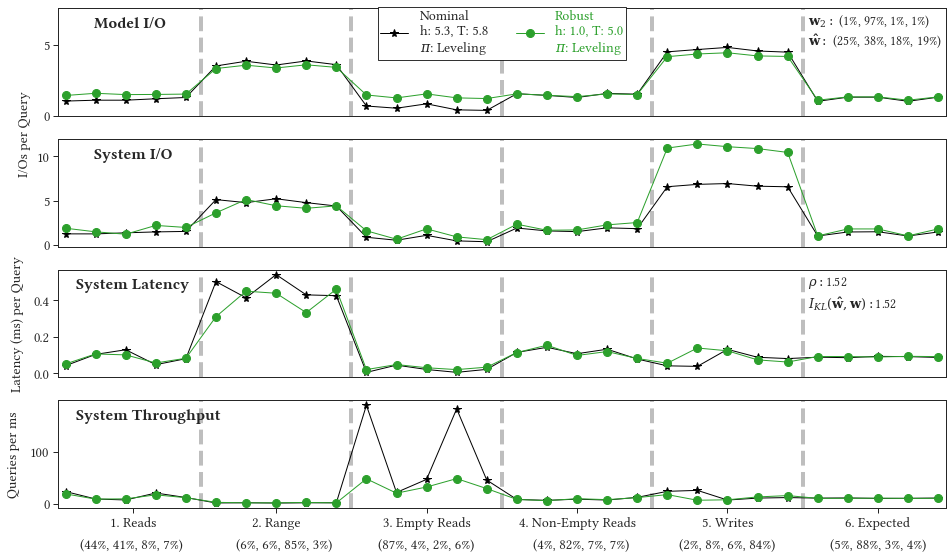

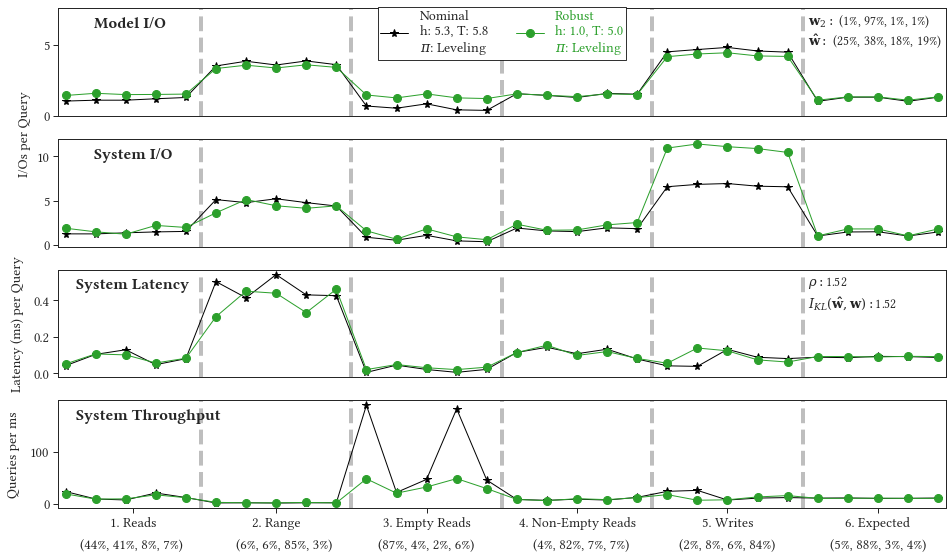

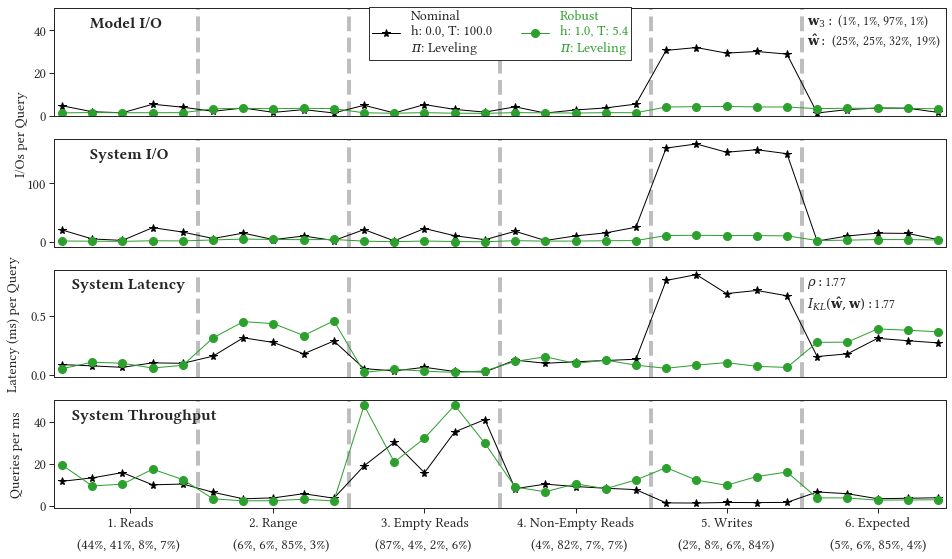

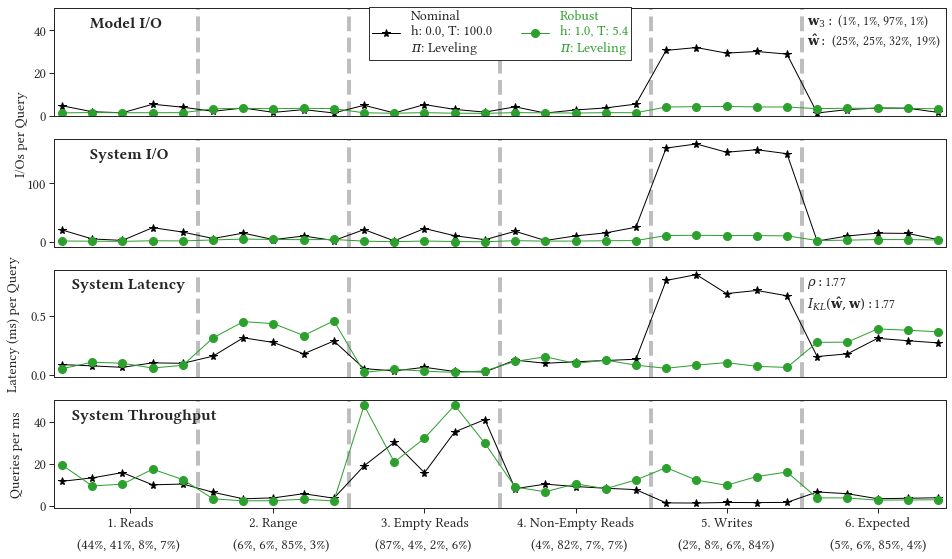

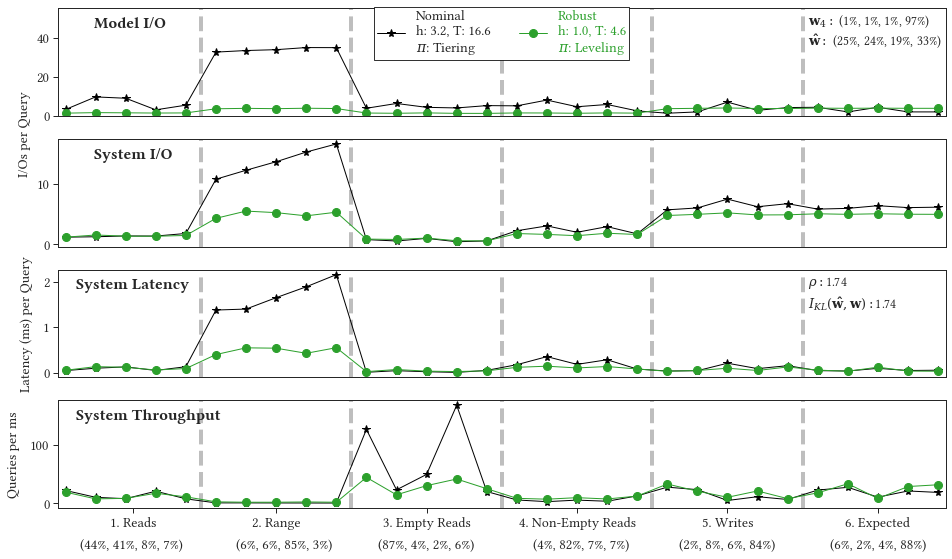

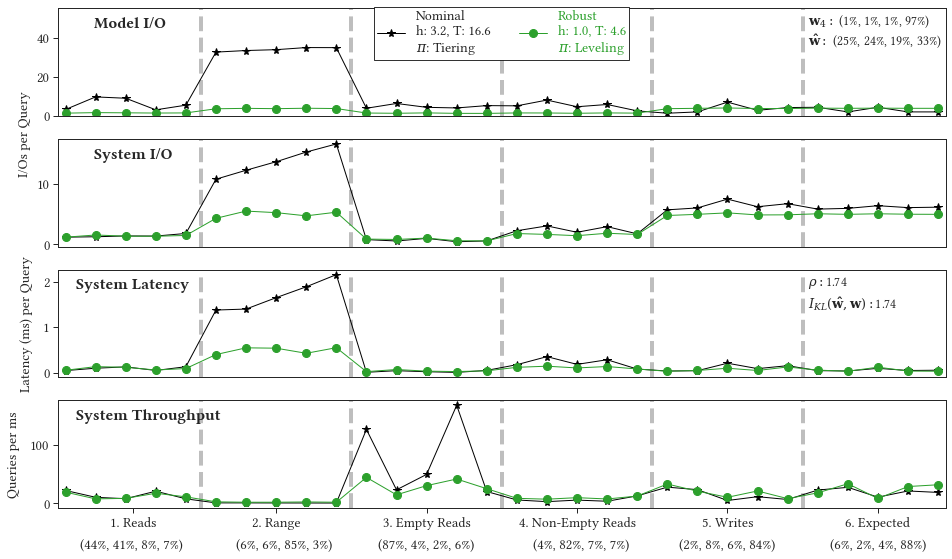

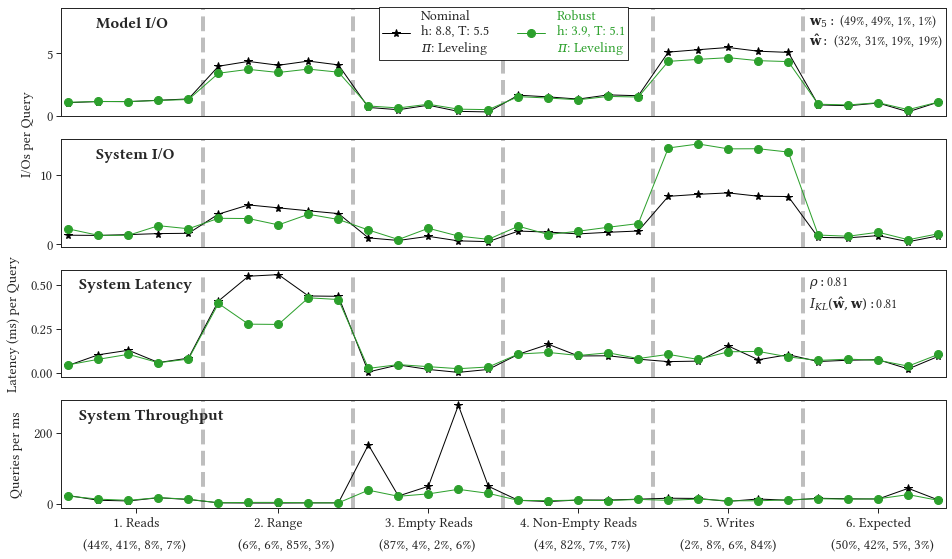

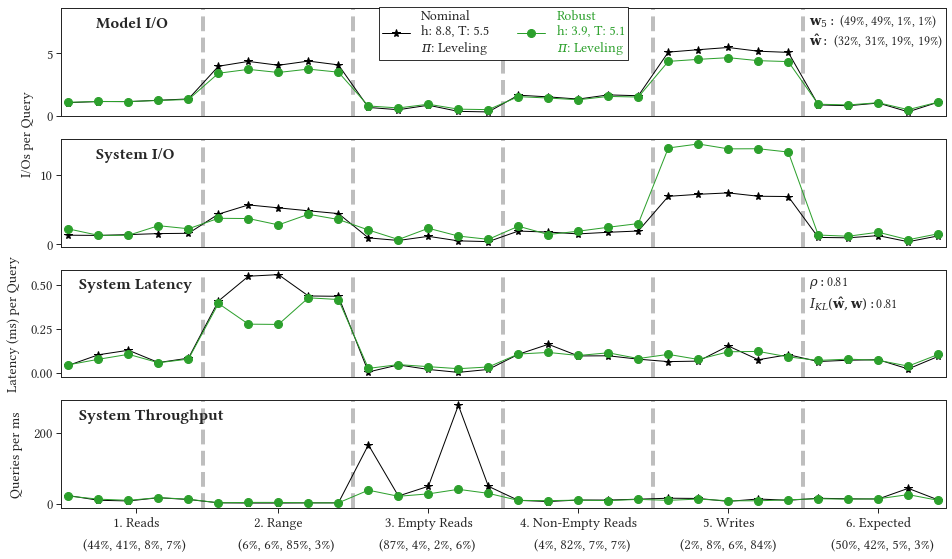

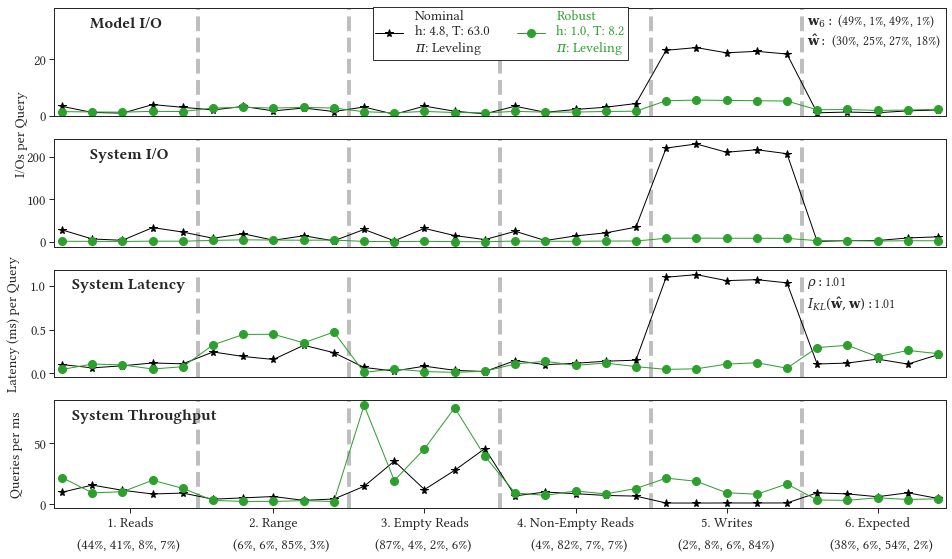

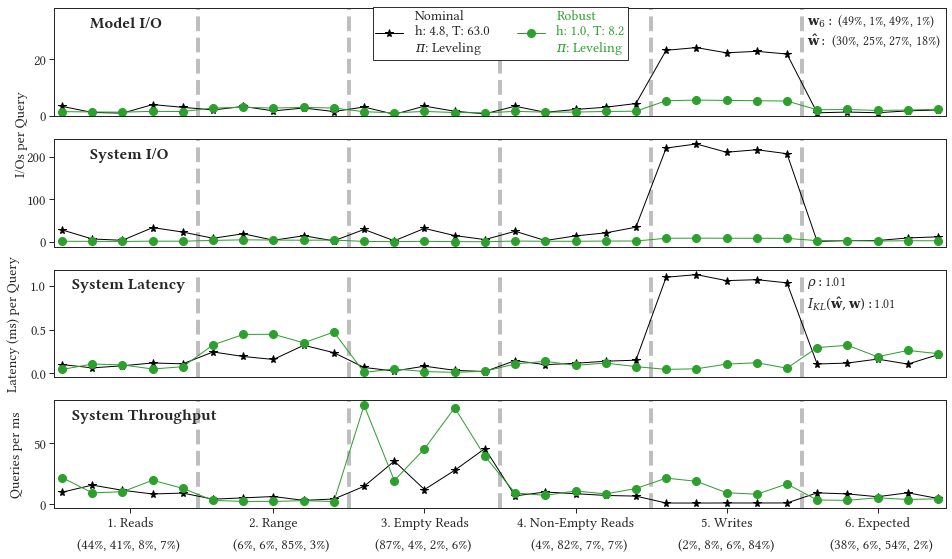

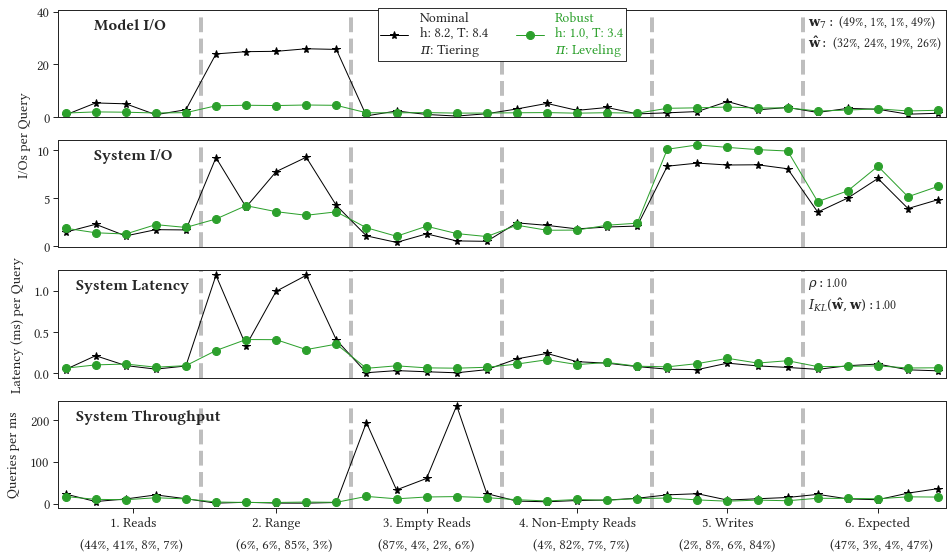

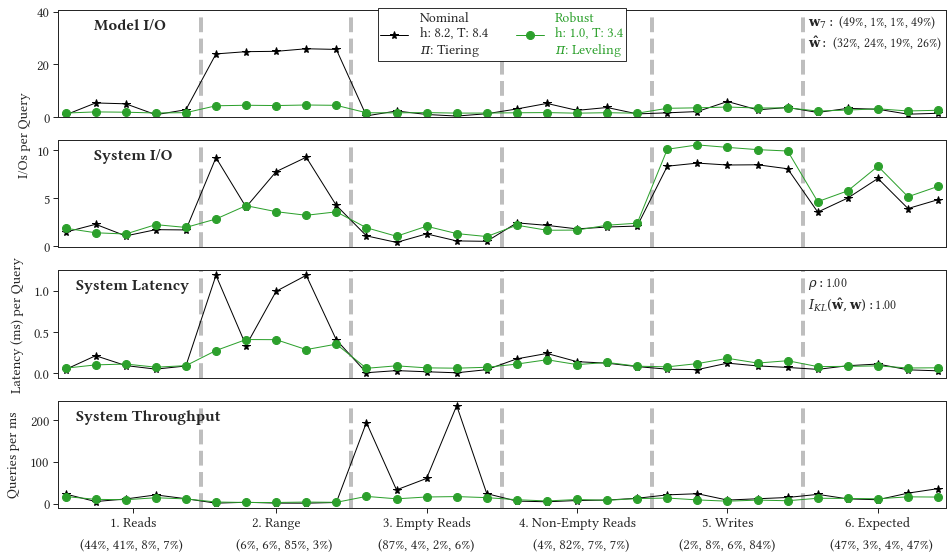

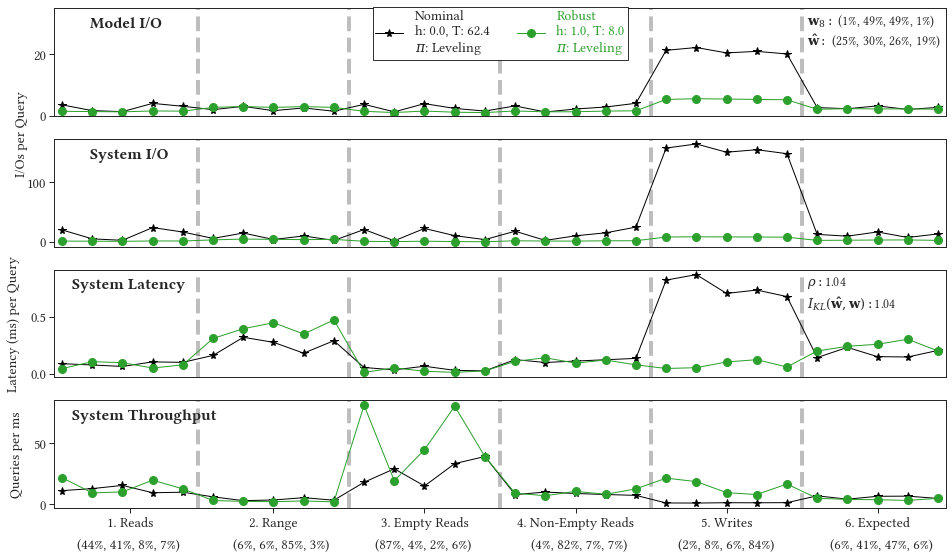

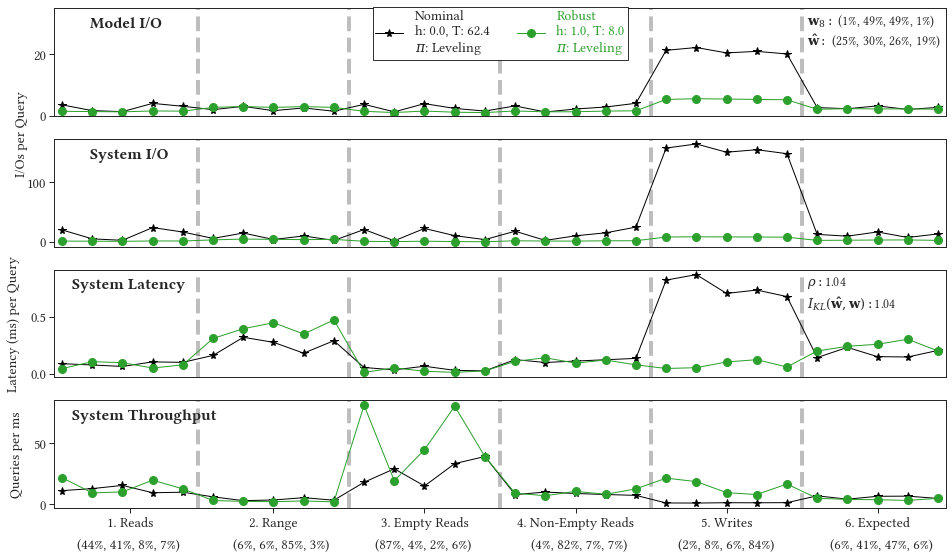

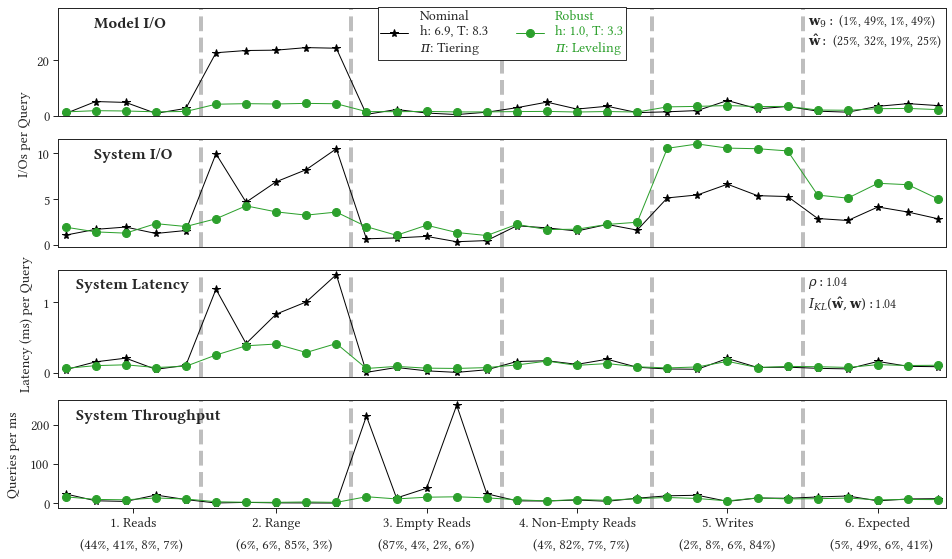

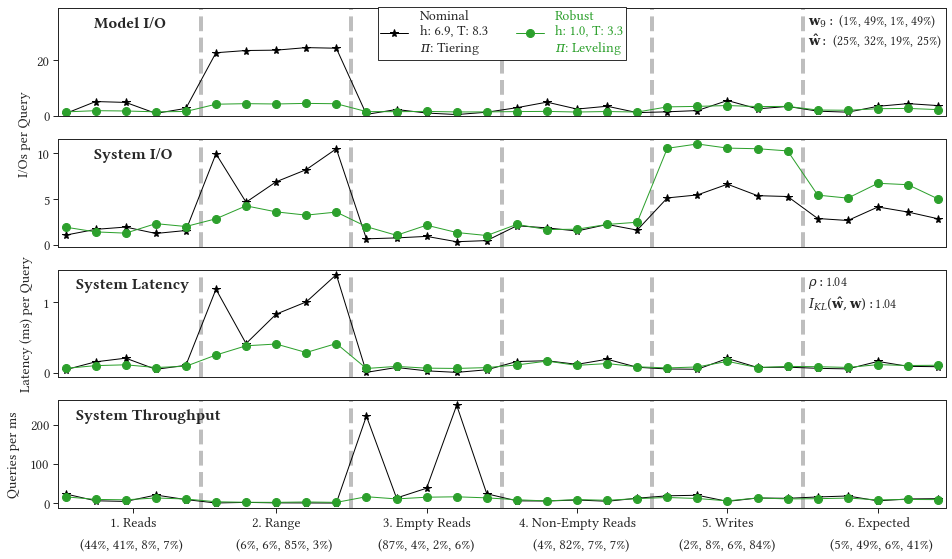

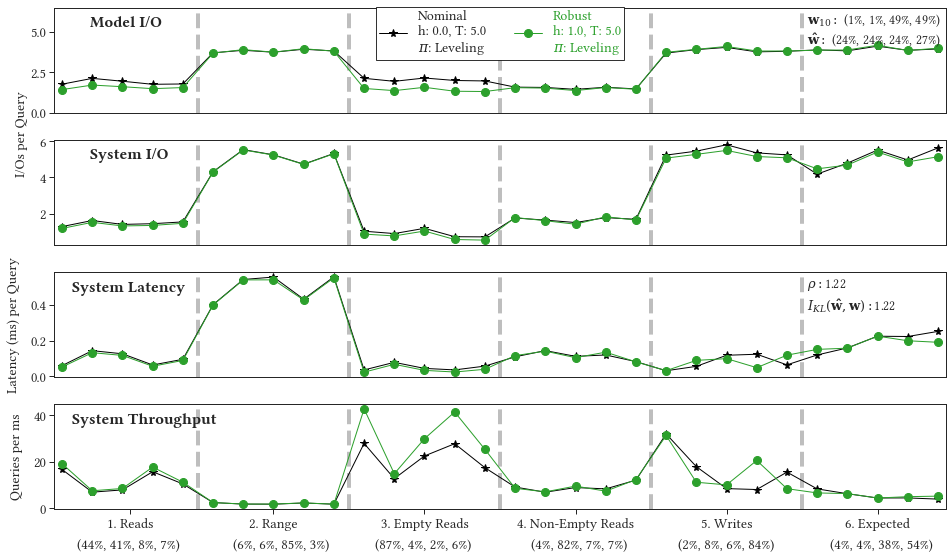

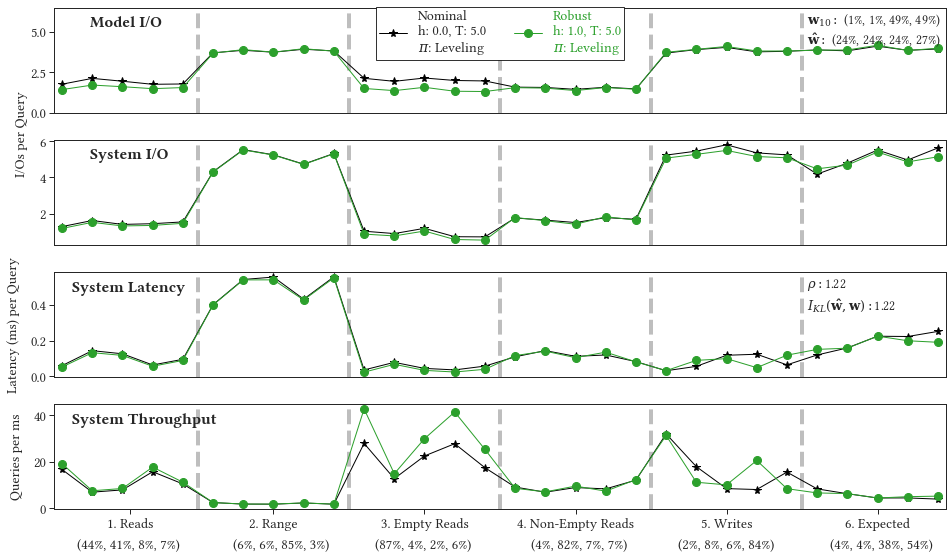

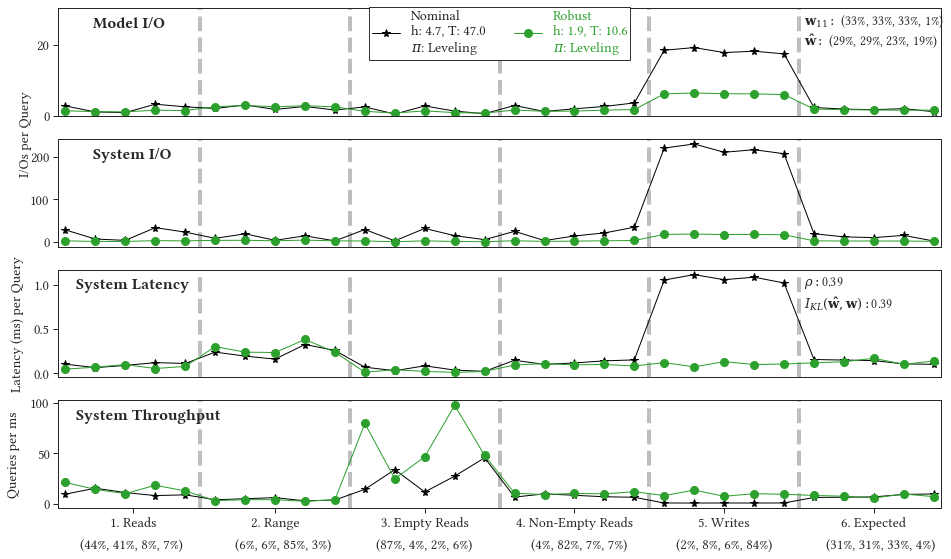

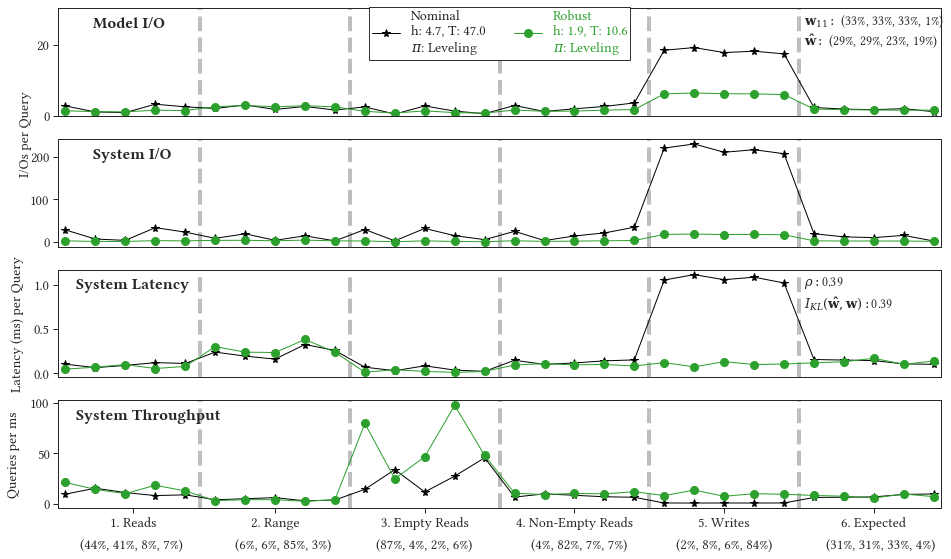

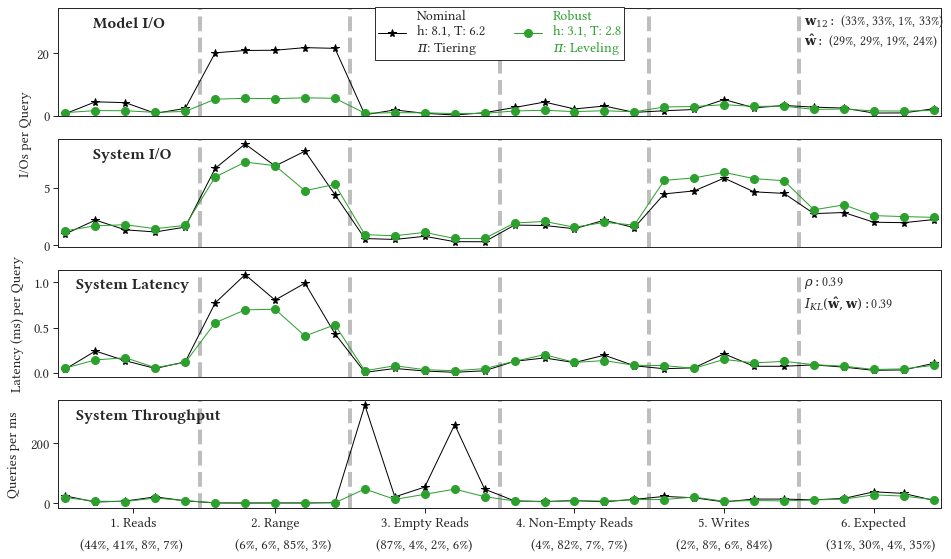

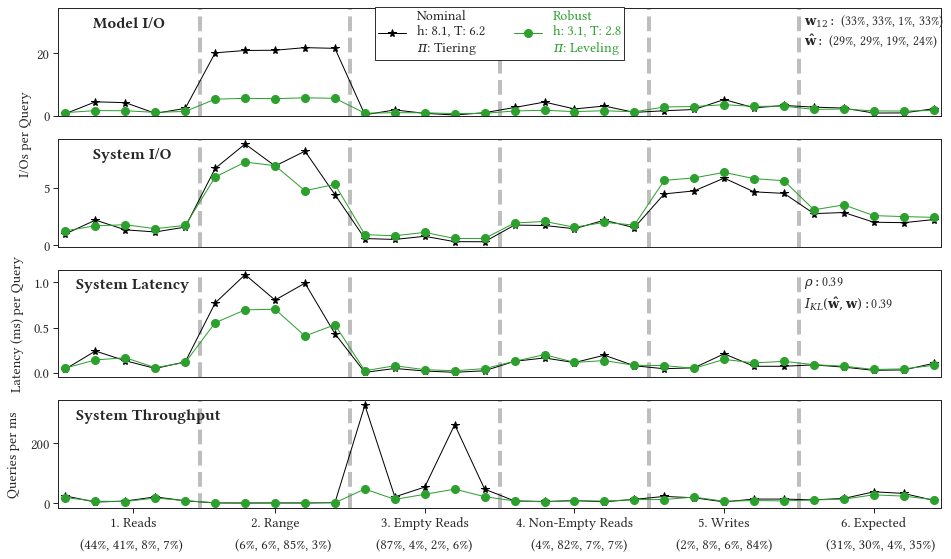

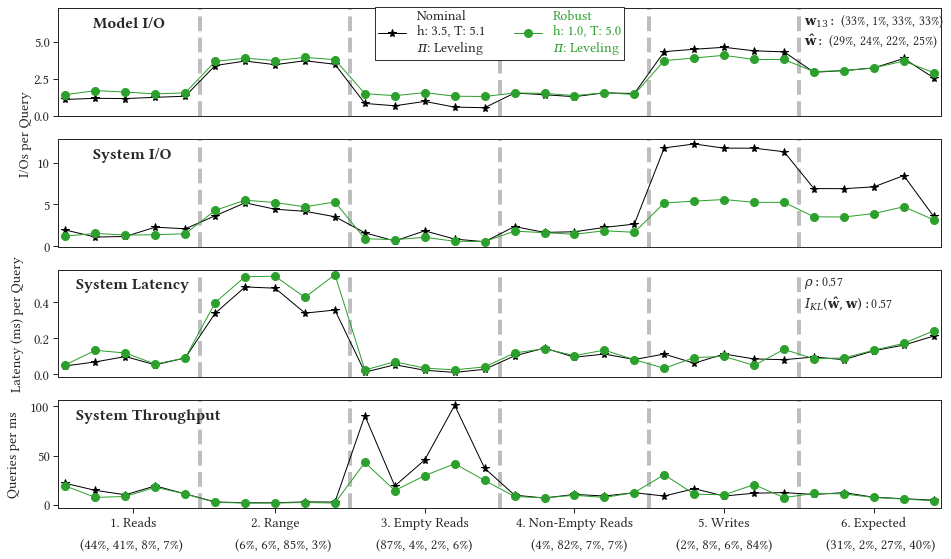

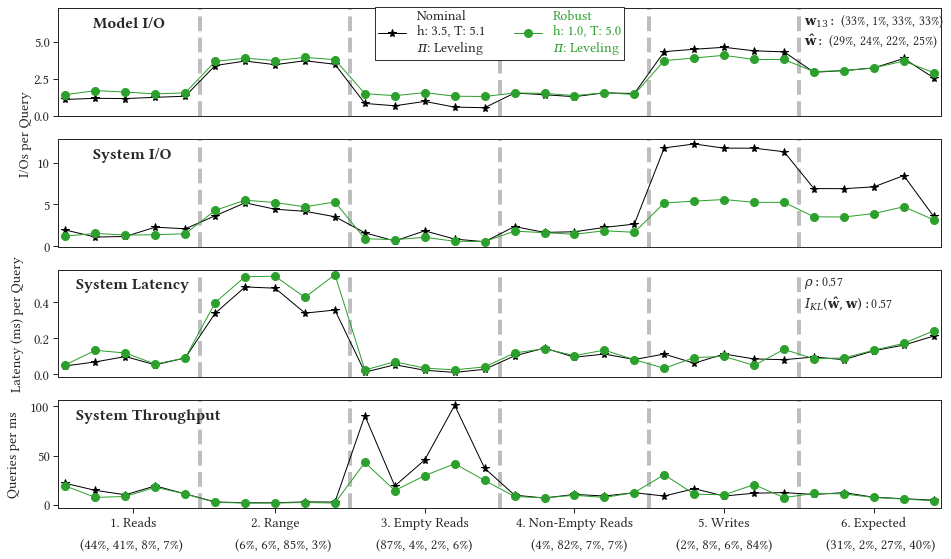

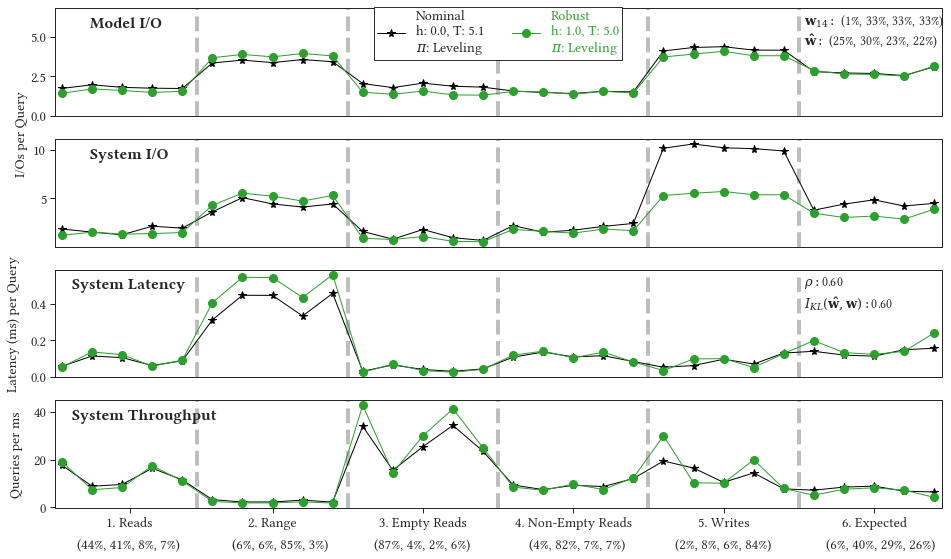

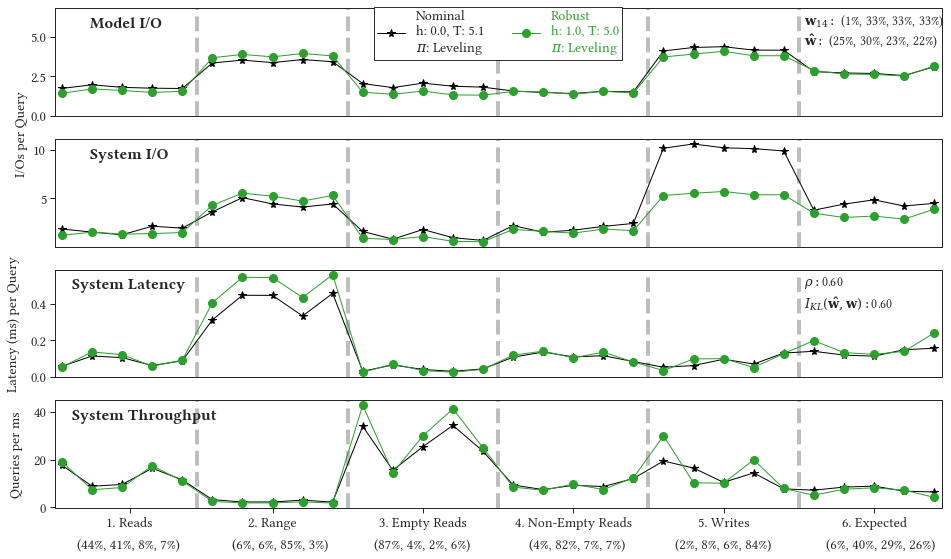

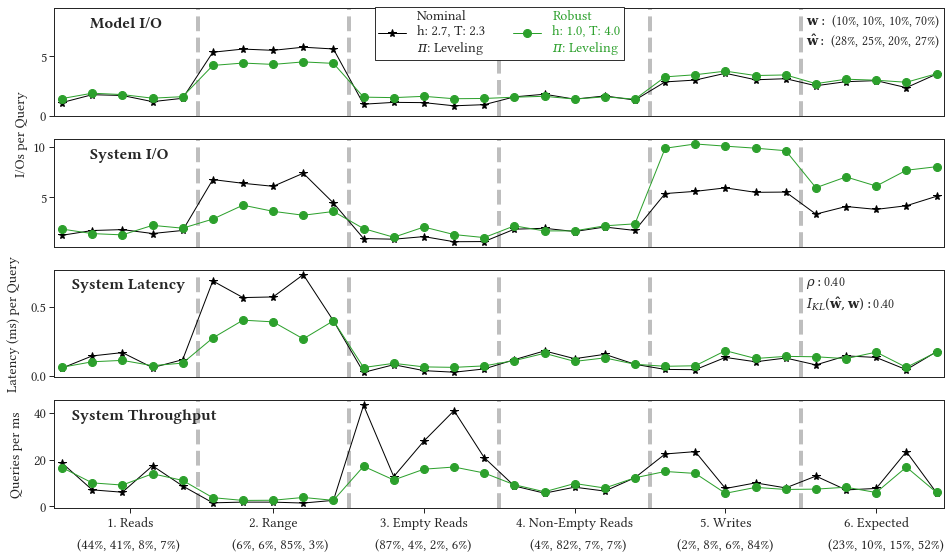

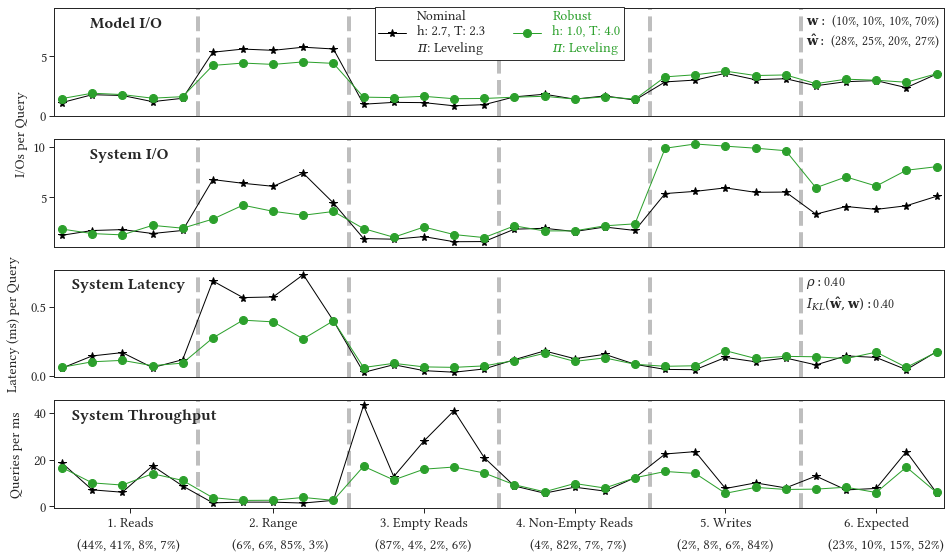

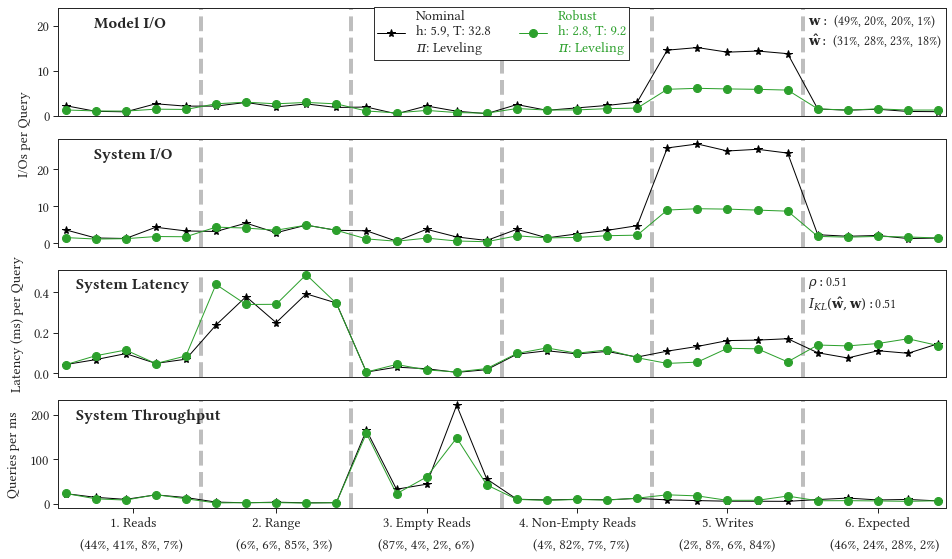

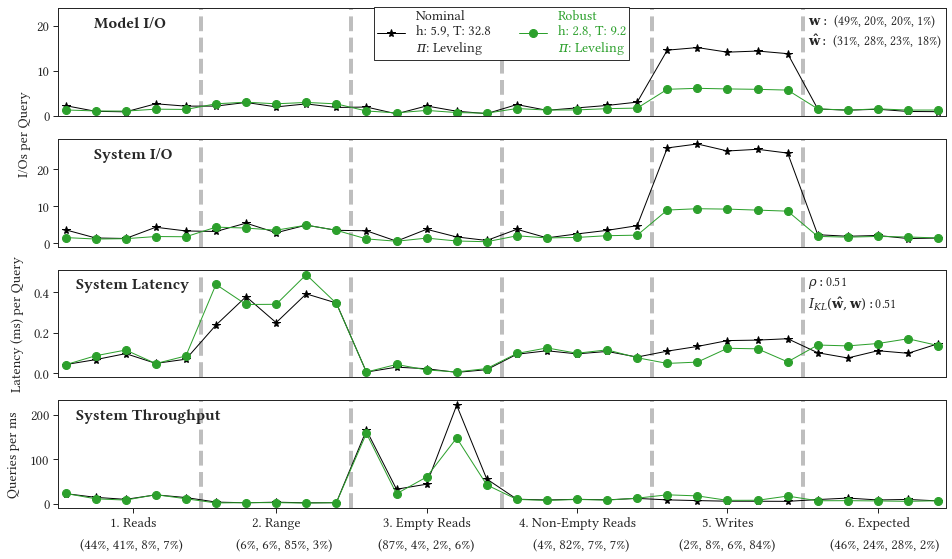

In [10]:
wl_idx, N, readonly = 8, 1e7, False
graphs = (True, True, True, True)

for wl_idx in range(0, 17):
    df_slice = df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index()
    df_slice = prep(df_slice)

    set_style()
    fig, axes = plot_cost_sessions(df_slice, graphs)
#     ymax = max([ax.get_ylim()[1] for ax in axes])
    axes[0].set_ylim([0, axes[0].get_ylim()[1] * 1.5])
#     axes[1].set_ylim([0, ymax])
    set_size(fig, width=14, height=sum(graphs)*2)

# Read Sequence 1
$\textbf{w}_{7} = (49\%, 1\%, 1\%, 49\%)$

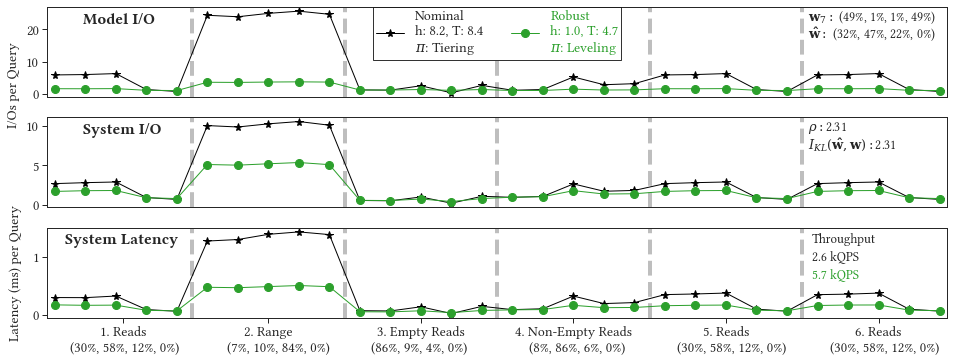

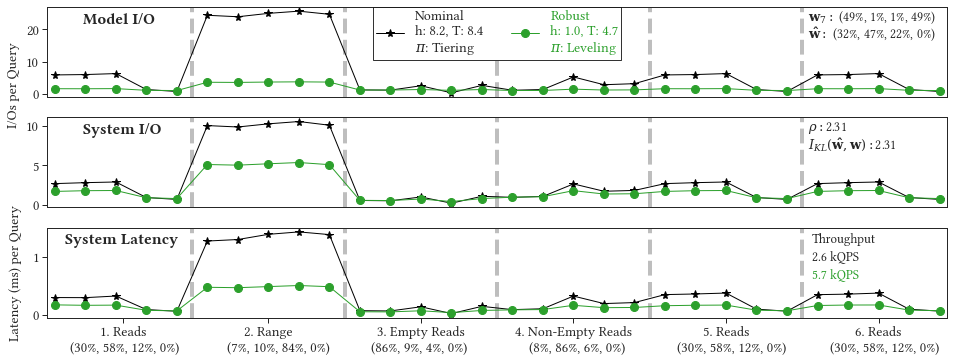

In [16]:
wl_idx, N = 7, 1e7
df1 = dp.read_csv('vldb/exp_03_no_writes.csv')
graphs = (True, True, True, False)
df_slice = df1[(df1['workload_idx'] == wl_idx) & (df1['N'] == N)].reset_index()
df_slice = prep(df_slice, readonly=True)
set_style()
fig, axes = plot_cost_sessions(df_slice, graphs, readonly=True)
# axes[1].set_ylim([0, 20])
set_size(fig, width=14, height=sum(graphs)*1.75)

s = df_slice.sum()
s['nominal_tp'] = s['num_queries'] / s['nominal_ms']
s['robust_tp'] = s['num_queries'] / s['robust_ms']
nom_tp, robust_tp = s[['nominal_tp', 'robust_tp']]

ax = axes[-1]
ax.text(0.85, 0.83, 'Throughput', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.63, f'{nom_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.43, f'{robust_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13, color='tab:green')
    
save_fig(fig, 'query_seq_read_1.pdf')

# Write Sequence 1 
$\textbf{w} = (10\%, 10\%, 10\%, 70\%)$

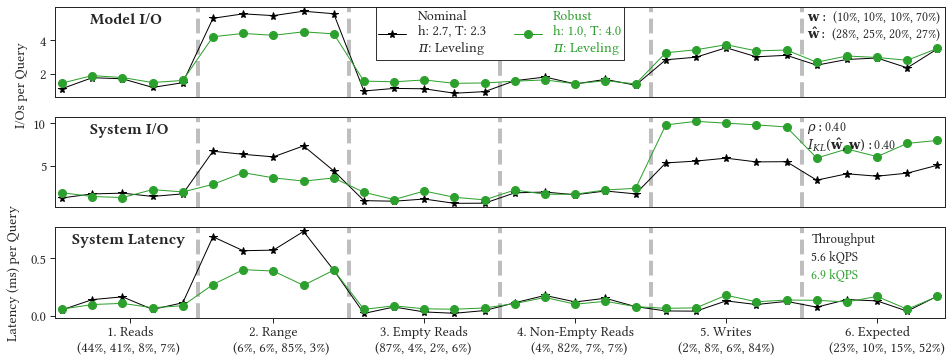

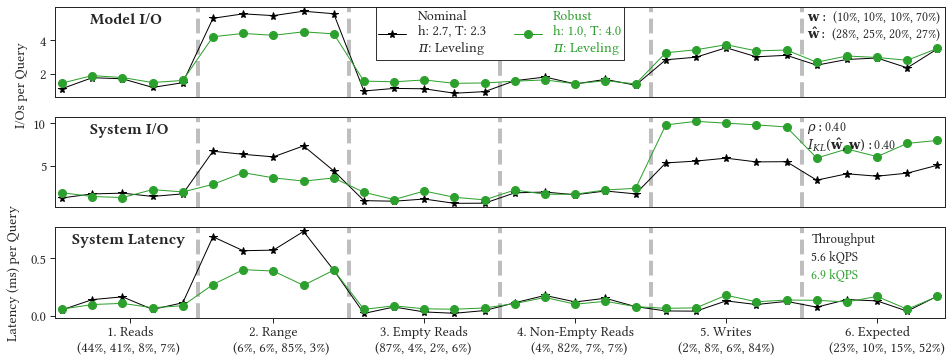

In [17]:
df = dp.read_csv('vldb/exp_03_pt02.csv')
wl_idx, N, readonly = 15, 1e7, False
graphs = (True, True, True, False)

df_slice = df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index()
df_slice = prep(df_slice)

set_style()
fig, axes = plot_cost_sessions(df_slice, graphs)
# ymax = max([ax.get_ylim()[1] for ax in axes])
# axes[0].set_ylim([0, 13])
# axes[1].set_ylim([0, 12])

s = df_slice.sum()
s['nominal_tp'] = s['num_queries'] / s['nominal_ms']
s['robust_tp'] = s['num_queries'] / s['robust_ms']
nom_tp, robust_tp = s[['nominal_tp', 'robust_tp']]

ax = axes[-1]
ax.text(0.85, 0.83, 'Throughput', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.63, f'{nom_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.43, f'{robust_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13, color='tab:green')

set_size(fig, width=14, height=sum(graphs)*1.75)
save_fig(fig, 'query_seq_hybrid_1.pdf')

# Read Sequence 2
$\textbf{w}_{11} = (33\%, 33\%, 33\%, 1\%)$

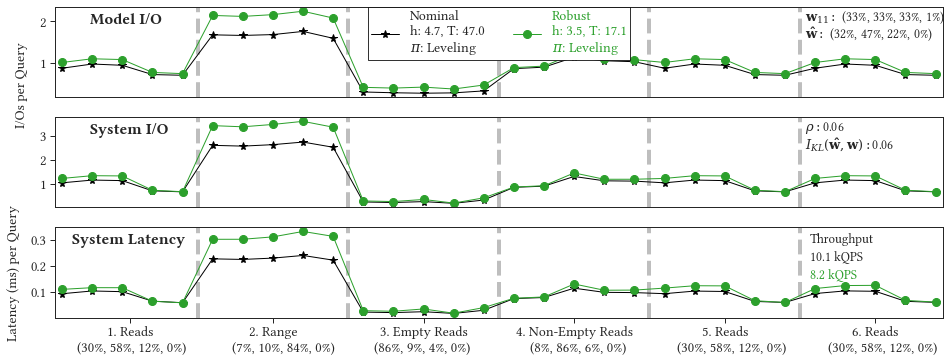

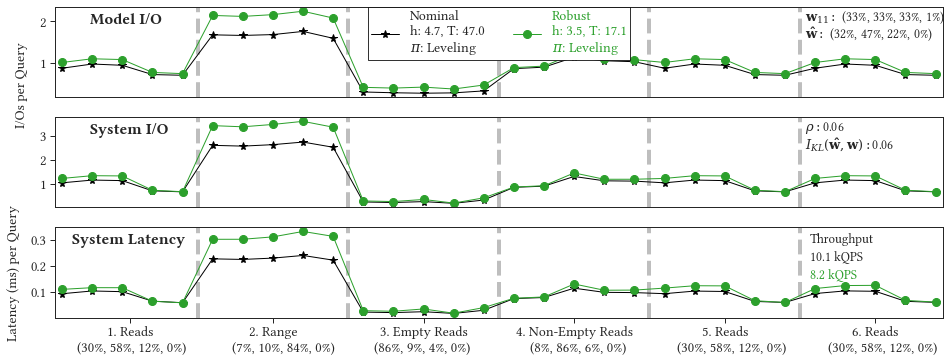

In [18]:
# df = dp.read_csv('vldb/exp_05_no_writes_unique.csv')
df = dp.read_csv('vldb/exp_03_no_writes.csv')
wl_idx, N, readonly = 11, 1e7, True
graphs = (True, True, True, False)

df_slice = df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index()
df_slice = prep(df_slice, readonly)

set_style()
fig, axes = plot_cost_sessions(df_slice, graphs, readonly)

    
s = df_slice.sum()
s['nominal_tp'] = s['num_queries'] / s['nominal_ms']
s['robust_tp'] = s['num_queries'] / s['robust_ms']
nom_tp, robust_tp = s[['nominal_tp', 'robust_tp']]

ax = axes[-1]
ax.text(0.85, 0.83, 'Throughput', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.63, f'{nom_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.43, f'{robust_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13, color='tab:green')

set_size(fig, width=14, height=sum(graphs)*1.75)
save_fig(fig, 'query_seq_read_2.pdf')

# Write Sequence 2
$\textbf{w}_{11} = (33\%, 33\%, 33\%, 1\%)$

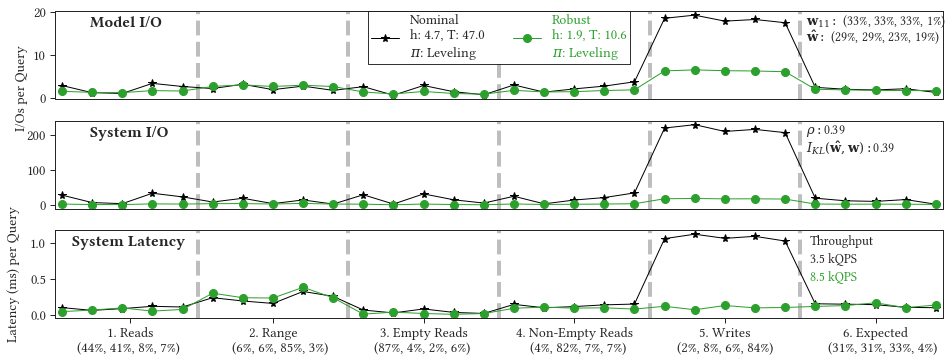

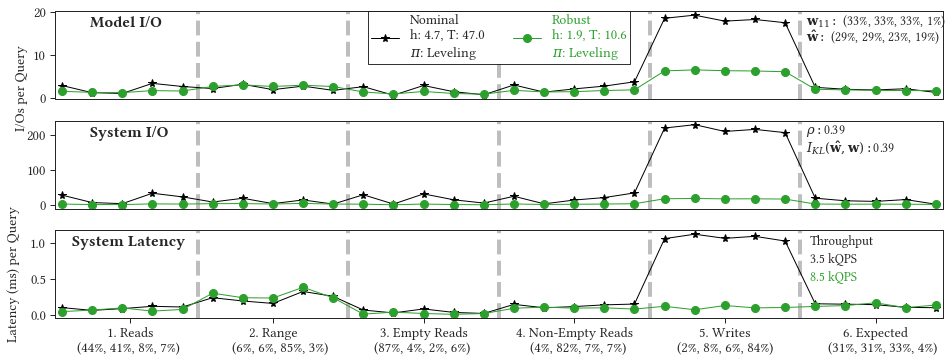

In [19]:
# df = dp.read_csv('vldb/exp_05_writes.csv')
df = dp.read_csv('vldb/exp_03_pt02.csv')
# df = dp.read_csv('exp_03_zipf_11.csv')
wl_idx, N, readonly = 11, 1e7, False
graphs = (True, True, True, False)

df_slice = prep(df[(df['workload_idx'] == wl_idx) & (df['N'] == N)].reset_index())

set_style()
fig, axes = plot_cost_sessions(df_slice, graphs, readonly)

s = df_slice.sum()
s['nominal_tp'] = s['num_queries'] / s['nominal_ms']
s['robust_tp'] = s['num_queries'] / s['robust_ms']
nom_tp, robust_tp = s[['nominal_tp', 'robust_tp']]

ax = axes[-1]
# rect = mpatches.Rectangle((0.91, 0.33), 0.09, 0.67, linewidth=1, edgecolor='k', facecolor='none', transform=ax.transAxes)
# ax.add_patch(rect)
# rect = mpatches.Rectangle((0.91, 0.78), 0.09, 0.22, linewidth=1, edgecolor='k', facecolor='none', transform=ax.transAxes)
# ax.add_patch(rect)
ax.text(0.85, 0.83, 'Throughput', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.63, f'{nom_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13)
ax.text(0.85, 0.43, f'{robust_tp:.1f} kQPS', transform=ax.transAxes, fontsize=13, color='tab:green')

set_size(fig, width=14, height=sum(graphs)*1.75)
save_fig(fig, 'query_seq_hybrid_2.pdf')

In [ ]:
s['nominal_ms']

In [ ]:
# sess_tp = {'nominal': [], 'robust': []}
# for idx in range(0, len(df_slice), 5):
#     sess_tp['nominal'].append(df_slice.loc[idx:idx+5]['num_queries'].sum() / df_slice.loc[idx:idx+5]['nominal_ms'].sum())
#     sess_tp['robust'].append(df_slice.loc[idx:idx+5]['num_queries'].sum() / df_slice.loc[idx:idx+5]['robust_ms'].sum())

# ax = axes[-1]
# start = 0.015
# xs = [start, start + 1/6, start + 2/6 - 0.005, start + 3/6, start + 4/6, start + 5/6]
# ys = [(0.59, 0.41), (0.49, 0.31), (0.59, 0.41), (0.59, 0.41), (0.59, 0.41), (0.59, 0.41)]
# off = [0.022, 0.022, 0.027, 0.027, 0.027, 0.027]
# for nom_tp, robust_tp, x, y, offset in zip(sess_tp['nominal'], sess_tp['robust'], xs, ys, off):
#     ax.text(x, y[0], f'{nom_tp:.1f}', transform=ax.transAxes, fontsize=13)
#     ax.text(x, y[1], f'{robust_tp:.1f}', transform=ax.transAxes, fontsize=13, color='tab:green')
#     ax.text(x + offset, sum(y) / 2, r'$\frac{query}{ms}$', transform=ax.transAxes, fontsize=13)

In [ ]:
# df = prep(dp.read_csv('vldb/exp_05_writes.csv'))
df = dp.read_csv('vldb/exp_03_pt02.csv')
tps = (
    df[df['N'] == 1e7].groupby('workload_idx')
    .apply(prep)
    .groupby('workload_idx')
    .sum()
    .assign(
        nominal_tp=lambda row: row['num_queries'] / row['nominal_ms'],
        robust_tp=lambda row: row['num_queries'] / row['robust_ms'],
    )
    .assign(
        speedup=lambda row: row['robust_tp'] / row['nominal_tp']
    )
)[['nominal_tp', 'robust_tp', 'speedup']].reset_index().drop('workload_idx', axis=1)
tunings = (
    df.groupby('workload_idx')
    .first()
    .reset_index()
    [['nominal_T', 'nominal_bpe', 'nominal_is_leveling_policy', 'robust_T', 'robust_bpe', 'robust_is_leveling_policy']]
)

df = pd.concat([tunings, tps], axis=1).round(2)
df

In [22]:
df = dp.read_csv('vldb/exp_03_pt02.csv')
tps = (
    df[df['N'] == 1e7].groupby('workload_idx')
    .apply(prep)
    .groupby('workload_idx')
    .sum()
    .assign(
        nominal_tp=lambda row: row['num_queries'] / row['nominal_ms'],
        robust_tp=lambda row: row['num_queries'] / row['robust_ms'],
    )
    .assign(
        delta_tp=lambda row: (row['robust_tp'] - row['nominal_tp']) / row['nominal_tp']
    )
)[['num_queries', 'nominal_ms', 'nominal_tp', 'robust_tp', 'delta_tp']].reset_index().drop('workload_idx', axis=1)
tps

num_queries  nominal_ms  nominal_tp  robust_tp  delta_tp
0     6000000.0    861614.0    6.963675   6.917009 -0.006701
1     6000000.0    705949.0    8.499198   8.866427  0.043208
2     6000000.0    843068.0    7.116864   7.454611  0.047457
3     6000000.0   1466179.0    4.092270   5.816456  0.421328
4     6000000.0   2181003.0    2.751028   6.987803  1.540070
5     6000000.0    846773.0    7.085724   8.051638  0.136318
6     6000000.0   1728360.0    3.471499   6.288979  0.811603
7     6000000.0   1223291.0    4.904802   7.298808  0.488094
8     6000000.0   1426791.0    4.205241   6.523292  0.551229
9     6000000.0   1433078.0    4.186792   7.365397  0.759198
10    6000000.0   1032550.0    5.810857   6.026081  0.037038
11    6000000.0   1712302.0    3.504055   8.518795  1.431125
12    6000000.0   1236910.0    4.850798   5.888305  0.213884
13    6000000.0    826578.0    7.258843   6.243945 -0.139815
14    6000000.0    848178.0    7.073987   6.075556 -0.141141
15    6000000.0   1072223.0    5.595851   6.941118  0.240404
16    6000000.0    755216.0    7.944747   7.358189 -0.073830

num_queries  nominal_ms  nominal_tp  robust_tp  delta_tp
0     6000000.0    861614.0    6.963675   6.917009 -0.006701
1     6000000.0    705949.0    8.499198   8.866427  0.043208
2     6000000.0    843068.0    7.116864   7.454611  0.047457
3     6000000.0   1466179.0    4.092270   5.816456  0.421328
4     6000000.0   2181003.0    2.751028   6.987803  1.540070
5     6000000.0    846773.0    7.085724   8.051638  0.136318
6     6000000.0   1728360.0    3.471499   6.288979  0.811603
7     6000000.0   1223291.0    4.904802   7.298808  0.488094
8     6000000.0   1426791.0    4.205241   6.523292  0.551229
9     6000000.0   1433078.0    4.186792   7.365397  0.759198
10    6000000.0   1032550.0    5.810857   6.026081  0.037038
11    6000000.0   1712302.0    3.504055   8.518795  1.431125
12    6000000.0   1236910.0    4.850798   5.888305  0.213884
13    6000000.0    826578.0    7.258843   6.243945 -0.139815
14    6000000.0    848178.0    7.073987   6.075556 -0.141141
15    6000000.0   1072223.0    5.595851   6.941118  0.240404
16    6000000.0    755216.0    7.944747   7.358189 -0.073830

In [ ]:
df